<a href="https://colab.research.google.com/github/goldenfries100/171Group14/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import torch
import torchvision
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.models import save_model, load_model
import cv2
from mlxtend.evaluate import scoring
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier

!pip install selectivesearch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! git clone https://github.com/goldenfries100/171Group14 data

Mounted at /content/drive
Cloning into 'data'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 58 (delta 10), reused 37 (delta 4), pack-reused 9
Receiving objects: 100% (58/58), 162.64 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (26/26), done.


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [ ]:
file = r'/content/data/cifar-10-batches-py/batches.meta'
batches_meta_file = unpickle(file)
print(batches_meta_file)

data_batch_1_file = r'/content/data/cifar-10-batches-py/data_batch_1'
#dataset_1 = pd.Series(unpickle(data_batch_1_file))
dataset_1 = unpickle(data_batch_1_file)
#The size of the 1st data batch is (10000 , 3072):- It contains 10000 images and each image as 3072 numerical entries:- 1024 for Red, Green, Blue respectively.
image = dataset_1['data'][0]
# In the reshape function, the first argument represent the color scaling we are using, for our case, since we have colored image, therefore the color code is 3. And our each image is of the size 32 x 32 pixels.
image = image.reshape(3,32,32)
# the standard order of the axes is 0, 1, 2 which represents:- width x height x no. of channels.
image = image.transpose(1,2,0)

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


(25, 32, 32, 3)
['dog', 'airplane', 'airplane', 'horse', 'automobile', 'truck', 'airplane', 'cat', 'deer', 'horse', 'deer', 'airplane', 'truck', 'deer', 'truck', 'cat', 'dog', 'ship', 'ship', 'bird', 'horse', 'horse', 'airplane', 'airplane', 'bird']
(25, 32, 32, 3)


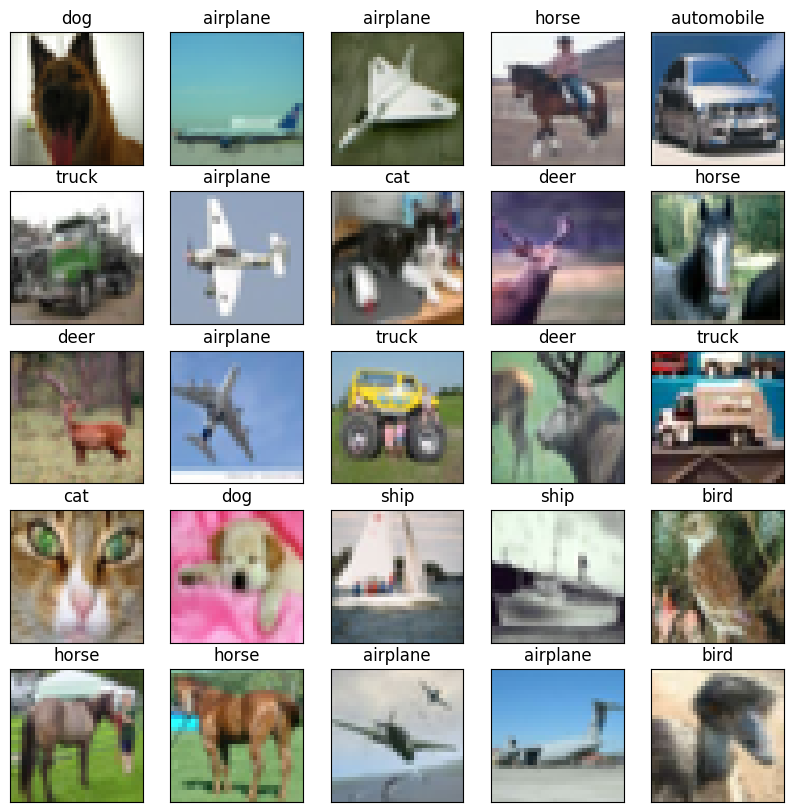

In [ ]:
# Python 3 program to visualize 4th image
import matplotlib.pyplot as plt
import numpy as np
# take the images data from batch data
images = dataset_1['data']
# reshape and transpose the images
# the arguments to reshape function are of the form (nb_samples, nb_channels, width, height)
images = images.reshape(len(images),3,32,32).transpose(0, 2, 3, 1)
# take labels of the images
labels = dataset_1['labels']
# label names of the images
label_names = batches_meta_file['label_names']
# display random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
print(images.shape)
# take labels for these images only
labels = [labels[i] for i in imageId]
# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
ln = [label_names[l] for l in labels]
print(ln)
print(images.shape)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()

### EDA(Exploratory Data Analysis)

(50000, 32, 32, 3)
--- The distribution of data images in dataset  1  --- 
 [1005  974 1032 1016  999  937 1030 1001 1025  981]


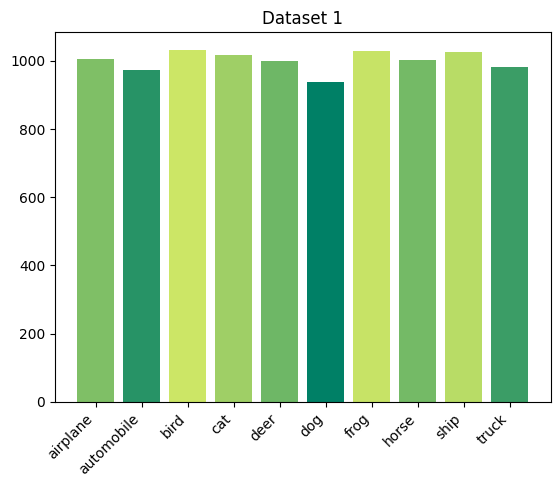

--- The distribution of data images in dataset  2  --- 
 [ 984 1007 1010  995 1010  988 1008 1026  987  985]


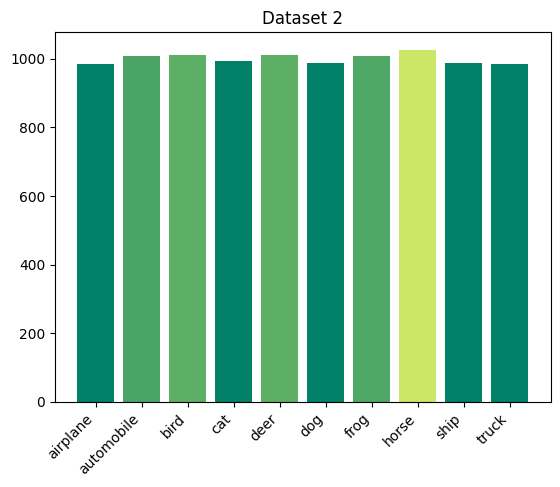

--- The distribution of data images in dataset  3  --- 
 [ 994 1042  965  997  990 1029  978 1015  961 1029]


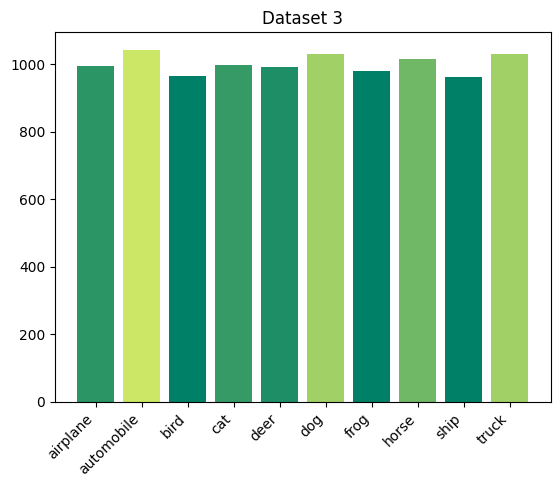

--- The distribution of data images in dataset  4  --- 
 [1003  963 1041  976 1004 1021 1004  981 1024  983]


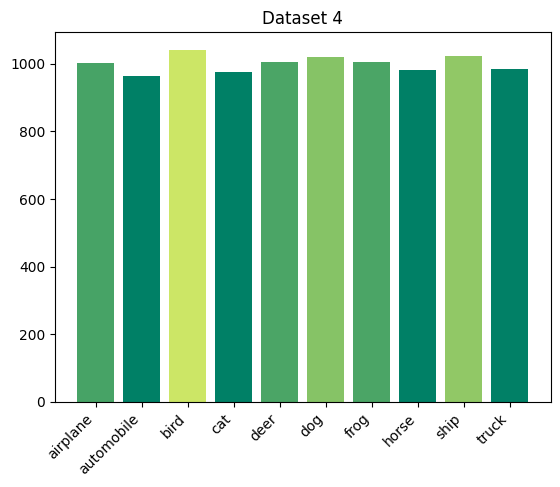

--- The distribution of data images in dataset  5  --- 
 [1014 1014  952 1016  997 1025  980  977 1003 1022]


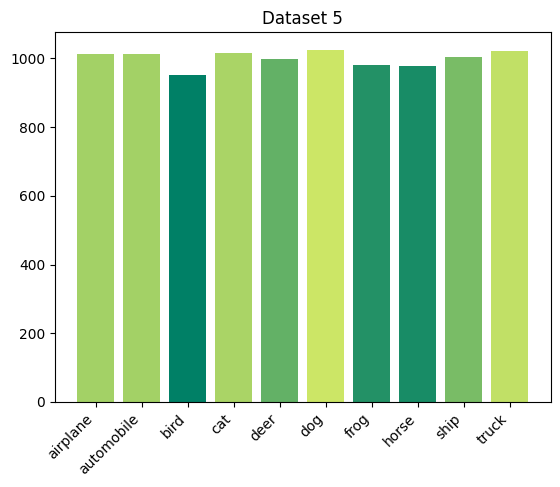

--- The total number of each class in the entire dataset is equal ---


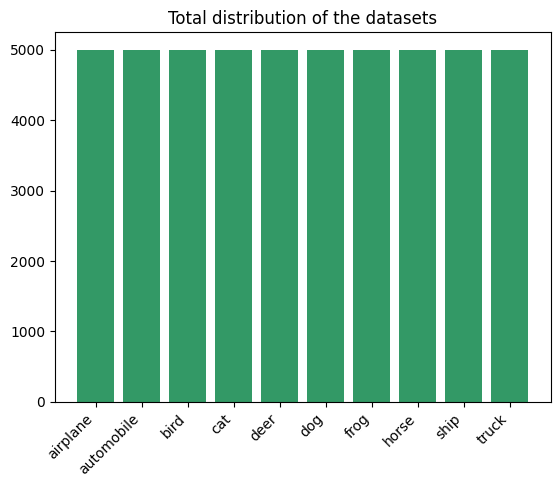

In [ ]:
NUM_DATASETS = 5
num_cases_per_batch = batches_meta_file['num_cases_per_batch']
label_names = batches_meta_file['label_names']
# random shuffling of data indices
random_image_indexes = (random.sample(range(num_cases_per_batch), num_cases_per_batch))
# complete dataset array
dataset_array = []
# the primary data in the dataset, contains a 50000 length array of 32x32x3 0-255 RGB values
images = []
# class labels for each image, a 50000 array of ints 0-9 corresponding to indices into label_names
labels = []
# iterate over each dataset
for i in range(NUM_DATASETS):
  # read i-th dataset from file
  dataset_array.append(unpickle(f'/content/data/cifar-10-batches-py/data_batch_{i+1}'))
  # reshape the images into readable RGB pixel format
  dataset_array[i]['data']
  # shuffle the images according to the random image indexes generated above
  images.append(dataset_array[i]['data'][random_image_indexes].reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1))
  # insert labels into labels list
  labels.append([dataset_array[i]['labels'][random_index] for random_index in random_image_indexes])

# convert to np array
labels = np.asarray(labels)
images = np.asarray(images).reshape(num_cases_per_batch * NUM_DATASETS, 32, 32, 3)
# convert into torch data
training_dataset = torch.from_numpy(images)
training_labels = torch.from_numpy(labels.flatten())

# display the number of occurences of each label in each dataset
cmap = plt.cm.summer
for i in range(NUM_DATASETS):
    counts = np.unique(labels[i], return_counts = True)
    print('--- The distribution of data images in dataset ',i+1,' --- \n', counts[1])
    bars = plt.bar(range(len(counts[0])), counts[1], align='center')
    plt.xticks(range(len(label_names)),label_names)
    plt.xticks(rotation=45, ha='right')
    plt.title('{}' .format('Dataset ' + str(i+1)))
    low = counts[1].min()+5
    high = counts[1].max() - low
    for j, bar in enumerate(bars):
      bar.set_facecolor(cmap((counts[1][j]-low)/high-0.2))
    plt.show()
total_counts = np.unique(labels.flatten(),return_counts = True)
print('--- The total number of each class in the entire dataset is equal ---')
bars = plt.bar(range(len(total_counts[0])),total_counts[1],align='center')
for bar in bars: bar.set_facecolor(cmap(0.2))
plt.xticks(range(len(label_names)),label_names)
plt.xticks(rotation=45, ha='right')
plt.title('Total distribution of the datasets')
plt.show()

###CNN

### The first block of code is building the convolutional base for the model.

 So essentially, the CNN model has two parts. One is the convolutional base part in which we try to reduce the number of nodes/parameters whihc will be fed into the neural network. Then the second part is actually building the neural network which predicts the class of the image based on the features.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 4.4 MB/s eta 0:00:00


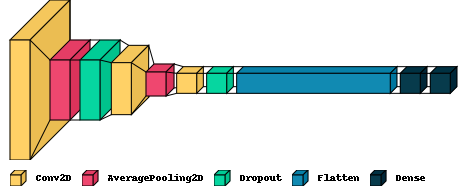

In [ ]:
!pip install visualkeras
import visualkeras
#hyperparameter tuning for the CNN.
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_model.add(layers.AveragePooling2D((2, 2)))
cnn_model.add(layers.Dropout(.1))
cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
cnn_model.add(layers.AveragePooling2D((2, 2)))
cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
cnn_model.add(layers.Dropout(.3))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(10, activation='sigmoid'))

visualkeras.layered_view(cnn_model, legend = True)


In [ ]:
cnn_model.summary()
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### getting the testing images and testing labels.

test_batch_read = r'/content/data/cifar-10-batches-py/test_batch'
test_batch = unpickle(test_batch_read)


test_labels_read = test_batch['labels']
### doing this because image_indexes is a random array of numbers
test_labels_indexed = [test_labels_read[i] for i in random_image_indexes]

test_images = test_batch['data']
test_images = test_images.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
test_images_indexed = test_images[random_image_indexes]
### multiples of 32 for batch size
### maybe implement yolo model in pytorch package.
trained_model = cnn_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=10, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 average_pooling2d (Average  (None, 15, 15, 64)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 96)        55392     
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 96)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 96)          8

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 176s 111ms/step - loss: 1.5311 - accuracy: 0.4422 - val_loss: 1.2711 - val_accuracy: 0.5407
Epoch 2/10
1563/1563 [==============================] - 149s 95ms/step - loss: 1.1933 - accuracy: 0.5752 - val_loss: 1.0626 - val_accuracy: 0.6200
Epoch 3/10
1563/1563 [==============================] - 149s 95ms/step - loss: 1.0406 - accuracy: 0.6316 - val_loss: 1.0123 - val_accuracy: 0.6397
Epoch 4/10
1563/1563 [==============================] - 151s 97ms/step - loss: 0.9386 - accuracy: 0.6679 - val_loss: 0.9044 - val_accuracy: 0.6840
Epoch 5/10
1563/1563 [==============================] - 148s 95ms/step - loss: 0.8560 - accuracy: 0.6997 - val_loss: 0.8563 - val_accuracy: 0.6986
Epoch 6/10
1563/1563 [==============================] - 147s 94ms/step - loss: 0.7980 - accuracy: 0.7183 - val_loss: 0.8644 - val_accuracy: 0.7035
Epoch 7/10
1563/1563 [==============================] - 147s 94ms/step - loss: 0.7406 - accuracy: 0.7383 - val_loss: 0.8014 - va

313/313 [==============================] - 11s 35ms/step
[0.9888081  0.13399102 0.90705377 0.5890459  0.33916306 0.11605457
 0.20357794 0.848693   0.16584256 0.06995631]


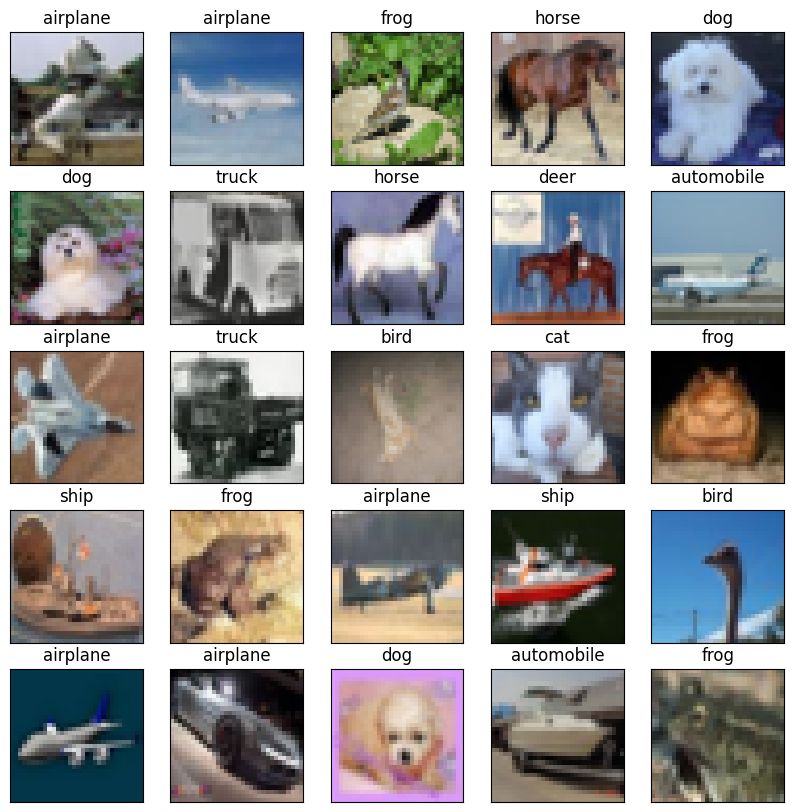

In [ ]:
labels_predicted = cnn_model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]

# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()

In [ ]:
#print(np.array(test_labels_indexed).shape)
test_loss, test_accuracy = cnn_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))

313/313 [==============================] - 15s 49ms/step - loss: 0.7934 - accuracy: 0.7270


The accuracy for the CNN model is:-  72.69999980926514 %
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       990
           1       0.84      0.89      0.87       951
           2       0.56      0.66      0.61       852
           3       0.61      0.51      0.55      1194
           4       0.65      0.72      0.68       904
           5       0.58      0.67      0.62       869
           6       0.89      0.63      0.74      1429
           7       0.73      0.81      0.77       902
           8       0.81      0.87      0.84       928
           9       0.82      0.83      0.83       981

    accuracy                           0.73     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.74      0.73      0.73     10000



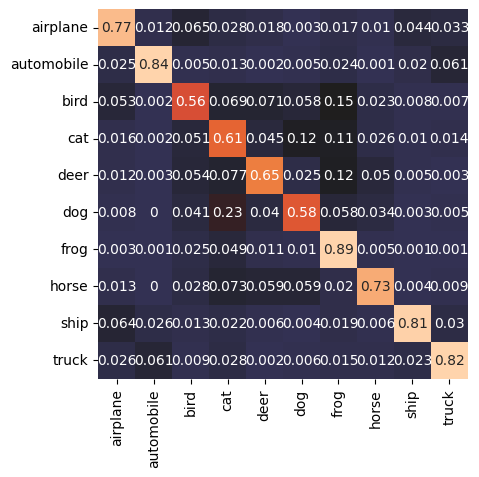

In [ ]:
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
print('The accuracy for the CNN model is:- ', test_accuracy * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names,cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

### Naive Bayes Classifier model

In [ ]:
nb = GaussianNB()
image_num, image_height, image_width, scale = training_dataset.shape
nb.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

GaussianNB()

The accuracy of the Naive Bayes Classifier for Gaussian pdf is:-  29.759999999999998 %
              precision    recall  f1-score   support

           0       0.49      0.27      0.35      1817
           1       0.17      0.41      0.24       405
           2       0.08      0.19      0.12       443
           3       0.08      0.25      0.12       305
           4       0.42      0.24      0.30      1737
           5       0.26      0.31      0.29       840
           6       0.47      0.25      0.33      1846
           7       0.13      0.42      0.20       310
           8       0.47      0.39      0.42      1219
           9       0.41      0.38      0.39      1078

    accuracy                           0.30     10000
   macro avg       0.30      0.31      0.28     10000
weighted avg       0.39      0.30      0.32     10000



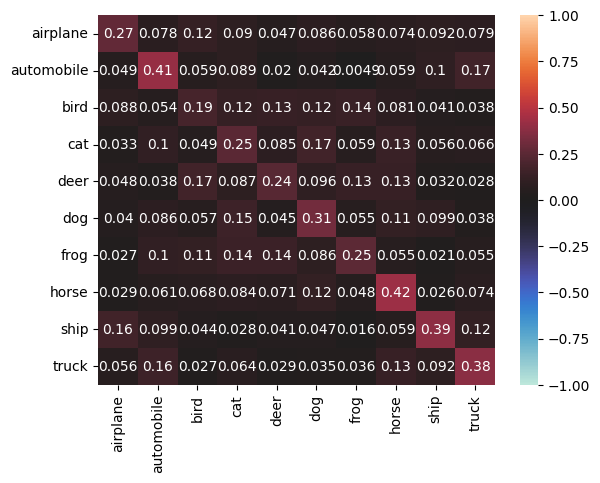

In [ ]:
test_num, test_image_height, test_image_width, scale_test = test_images_indexed.shape
predicted_labels = nb.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))
print('The accuracy of the Naive Bayes Classifier for Gaussian pdf is:- ', accuracy_score(predicted_labels, test_labels_indexed) * 100, '%')
matrix_nb = confusion_matrix(np.array(predicted_labels), test_labels_indexed, normalize='true')
sb.heatmap(matrix_nb, vmin=-1, vmax=1, center=0, xticklabels=label_names, yticklabels=label_names, annot=True)
print(classification_report(predicted_labels, np.array(test_labels_indexed)))

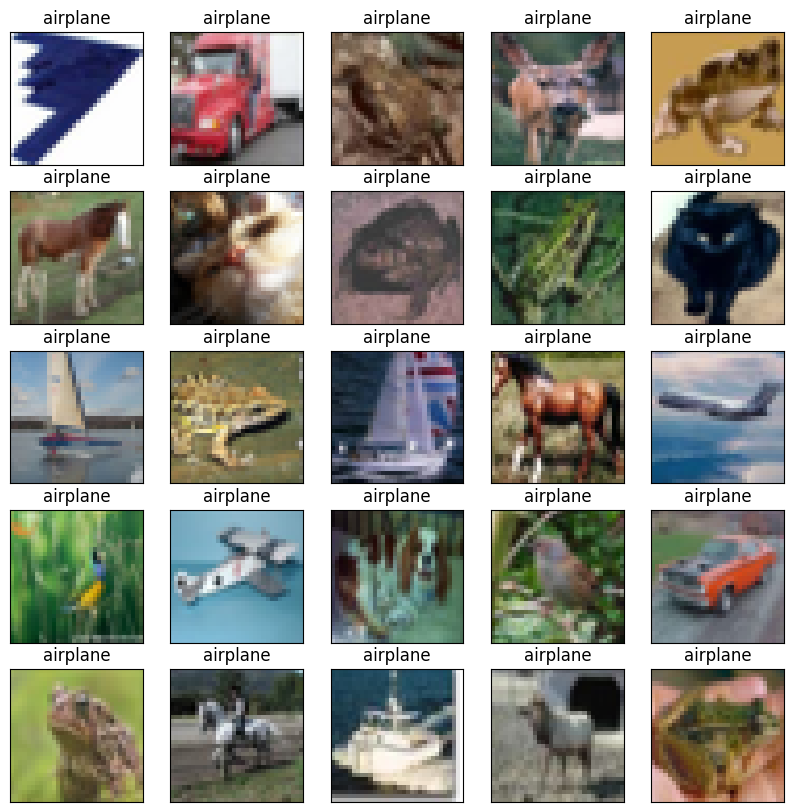

In [ ]:
max_label = []
max_label = [label_names[np.argmax(label)] for label in predicted_labels]
#print(max_label)
# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()

### KNN model (backup model)

In [ ]:
parameters = [{
    'n_neighbors': [10, 20, 30],
    'weights': ['uniform', 'distance']
}]

In [ ]:
knn_model_optimized = KNeighborsClassifier()
grid_model = GridSearchCV(estimator=knn_model_optimized, param_grid=parameters, cv=2, return_train_score=True, verbose=3)
grid_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END n_neighbors=10, weights=uniform;, score=(train=0.406, test=0.315) total time= 2.8min
[CV 2/2] END n_neighbors=10, weights=uniform;, score=(train=0.415, test=0.316) total time= 2.7min
[CV 1/2] END n_neighbors=10, weights=distance;, score=(train=1.000, test=0.326) total time= 2.7min
[CV 2/2] END n_neighbors=10, weights=distance;, score=(train=1.000, test=0.326) total time= 2.7min
[CV 1/2] END n_neighbors=20, weights=uniform;, score=(train=0.360, test=0.308) total time= 2.6min
[CV 2/2] END n_neighbors=20, weights=uniform;, score=(train=0.368, test=0.311) total time= 2.6min
[CV 1/2] END n_neighbors=20, weights=distance;, score=(train=1.000, test=0.315) total time= 2.6min
[CV 2/2] END n_neighbors=20, weights=distance;, score=(train=1.000, test=0.319) total time= 2.5min
[CV 1/2] END n_neighbors=30, weights=uniform;, score=(train=0.339, test=0.305) total time= 2.6min
[CV 2/2] END n_neighbors=30, weights=uniform;, score=(

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [10, 20, 30],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, verbose=3)

In [ ]:
print(grid_model.best_estimator_)

KNeighborsClassifier(n_neighbors=10, weights='distance')


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance')

In [ ]:
knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction = knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

              precision    recall  f1-score   support

           0       0.49      0.48      0.48      1017
           1       0.17      0.78      0.28       218
           2       0.40      0.24      0.30      1660
           3       0.17      0.31      0.22       559
           4       0.57      0.24      0.33      2408
           5       0.26      0.43      0.33       612
           6       0.32      0.33      0.33       960
           7       0.23      0.68      0.35       338
           8       0.73      0.37      0.49      1975
           9       0.18      0.72      0.29       253

    accuracy                           0.35     10000
   macro avg       0.35      0.46      0.34     10000
weighted avg       0.47      0.35      0.36     10000



<Axes: >

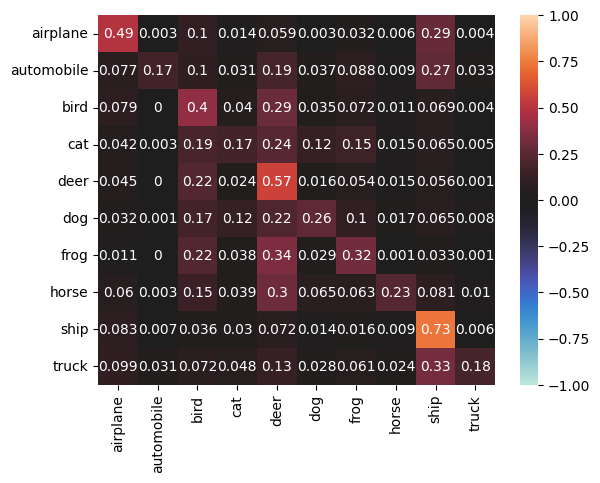

In [ ]:
print(classification_report(knn_prediction, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

### R-CNN model


For implementing the R-CNN model, we are going to use the inbuilt R-CNN model in the torchvision library. We are doing this because for the R-CNN model to work, we need ROI (Regions of interests) which is returned as an array of numbers which represent the coordinates of the box which might contain the label. The prediction using the inbuilt function would have three things:-  <br>
1. 'boxes':- This is an array of size n x 4 where n is the number of proposed regions we have specified for predicting the label of the image.
2. 'labels':- This an array of size (n,) which holds the index of the predicted label of the image for each region.
3. 'scores':- This is also an array of size (n,) which contains the scores/possibilities for each region.

Since couldn't get the box labels from the CNN model we implemented, therefore we are going to use the inbuilt models for implementing R-CNN.


Trying some stuff

In [ ]:
from torchvision import transforms as T
from torchvision.models import resnet50


### I think we should change the weights of the model.
cnn = tf.keras.models.load_model('/content/cnn_model.h5')
cnn_weights = cnn.get_weights()
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=cnn_weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
transform = T.ToTensor()
img = transform(test_images_indexed[2])
print(img.shape)
pred = model([img])

torch.Size([3, 32, 32])


In [ ]:
print(pred)

[{'boxes': tensor([[ 0.2018, 10.2301, 23.9561, 29.8660]], grad_fn=<StackBackward0>), 'labels': tensor([15]), 'scores': tensor([0.0990], grad_fn=<IndexBackward0>)}]
